# Behaviorial Cloning
---
*Term 1, Project 3 of Udacity Self-Driving Car Nanodegree, by vuiseng9, Sept 2017*

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import cv2
import matplotlib.pylab as plt
%matplotlib inline
np.random.seed(902)

### Data Collection & Selection

In [2]:
# Read in the data csv in to a panda dataframe
df = pd.read_csv("./data/driving_log.csv")

In [3]:
print("Number of frames from each camera:", len(df))

Number of frames from each camera: 7597


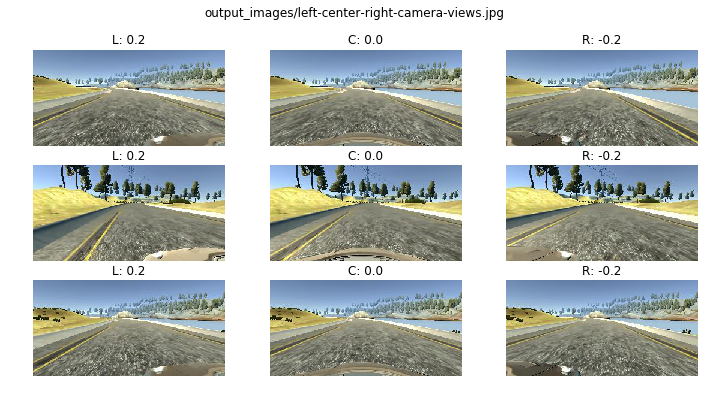

In [4]:
# Visualize the three camera views with steering angle
rows = 3
cols = 3
f, ax = plt.subplots(rows, cols, figsize=(cols*4,rows*2));

# Left Camera View: require a right steer - add correction value to center steering angle
# Right Camera View: require a left steer - deduct correction value to center steering angle
correction=0.2

for r, idx in enumerate(np.random.randint(0, len(df), 3)):
    l_cam = cv2.imread('./data/IMG/' + df.left[idx].split('/')[-1])
    c_cam = cv2.imread('./data/IMG/' + df.center[idx].split('/')[-1])
    r_cam = cv2.imread('./data/IMG/' + df.right[idx].split('/')[-1])
    
    ax[r,0].imshow(cv2.cvtColor(l_cam,cv2.COLOR_RGB2BGR)); ax[r,0].axis('off') 
    ax[r,0].set_title("L: " + str(round(df.steering[r]+correction,3)))
    
    ax[r,1].imshow(cv2.cvtColor(c_cam,cv2.COLOR_RGB2BGR)); ax[r,1].axis('off')
    ax[r,1].set_title("C: " + str(round(df.steering[r],3)))
    
    ax[r,2].imshow(cv2.cvtColor(r_cam,cv2.COLOR_RGB2BGR)); ax[r,2].axis('off') 
    ax[r,2].set_title("R: " + str(round(df.steering[r]-correction,3)))

# save figure
imgpth = 'output_images/left-center-right-camera-views.jpg'
f.suptitle(imgpth)
# f.tight_layout()
# f.subplots_adjust(top=0.95)
f.savefig(imgpth)

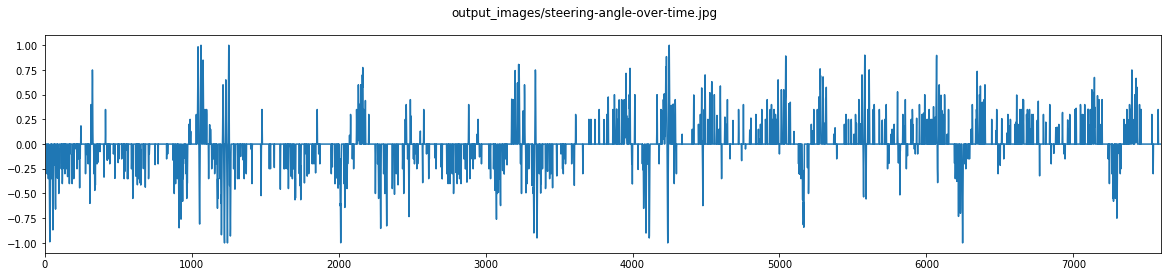

In [5]:
# Visualize the car steering over time
# +ve: steer right, -ve: steer left
df.steering.plot(figsize=(20,4))

# save figure
imgpth = 'output_images/steering-angle-over-time.jpg'
plt.suptitle(imgpth)
plt.savefig(imgpth)

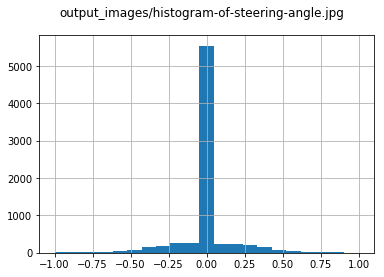

In [6]:
# Visualize steering angle distribution with histogram - only steering angle of center camera
nbins=21
df.steering.hist(bins=nbins)

# save figure
imgpth = 'output_images/histogram-of-steering-angle.jpg'
plt.suptitle(imgpth)
plt.savefig(imgpth)

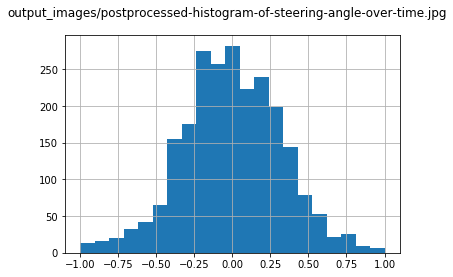

In [7]:
# Balancing Data
# Create a new DataFrame after Downsampling the images that with low steering angle
steer_straight_idx = df[(df.steering >= -0.045) & (df.steering <= 0.045)].index
downsample_idx = np.random.choice(steer_straight_idx,int(len(steer_straight_idx)*.05), )
new_idx = np.concatenate([df[~((df.steering >= -0.045) & (df.steering <= 0.045))].index, downsample_idx])
new_df = df.iloc[np.sort(new_idx)].reset_index(drop=True)
# New Steering Angle Distribution 
new_df.steering.hist(bins=nbins)

# save figure
imgpth = 'output_images/postprocessed-histogram-of-steering-angle-over-time.jpg'
plt.suptitle(imgpth)
plt.savefig(imgpth)

In [8]:
print("Postprocessed number of frames for each camera:", len(new_df))

Postprocessed number of frames for each camera: 2334


In [9]:
# Make list of image-steering angle pair
# Perform steering angle correction on left & right mounted camera frame
correction=0.2
samples = []
samples = np.vstack([np.hstack([new_df.left.values, 
                                new_df.center.values, 
                                new_df.right.values]),
                     np.hstack([new_df.steering+correction, 
                                new_df.steering, 
                                new_df.steering-correction])]).T.tolist()

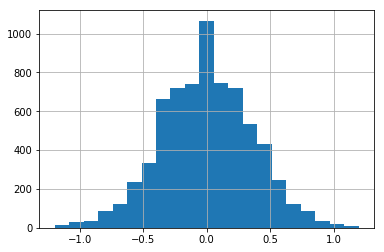

In [10]:
pd.Series(np.hstack([new_df.steering+correction, 
                                new_df.steering, 
                                new_df.steering-correction])).hist(bins=nbins)

### Data Augmentation

In [11]:
from skimage import transform #scikit-image for image transform API

#### 1. Randomize Lightning Conditions

In [12]:
def modify_sat_lum(image, uni_low=0.4, uni_high=1.6):
    sat_f, lum_f =np.random.uniform(uni_low, uni_high, 2).tolist()
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(float)
    hls[:,:,1] = hls[:,:,1] * lum_f
    hls[:,:,1][hls[:,:,1] > 255] = 255
    hls[:,:,2] = hls[:,:,2] * sat_f
    hls[:,:,2][hls[:,:,2] > 255] = 255
    return cv2.cvtColor(hls.astype('uint8'),cv2.COLOR_HLS2BGR)

Example of Random Change of Saturation and Luminisance to mimick different lightning conditions of the roads.

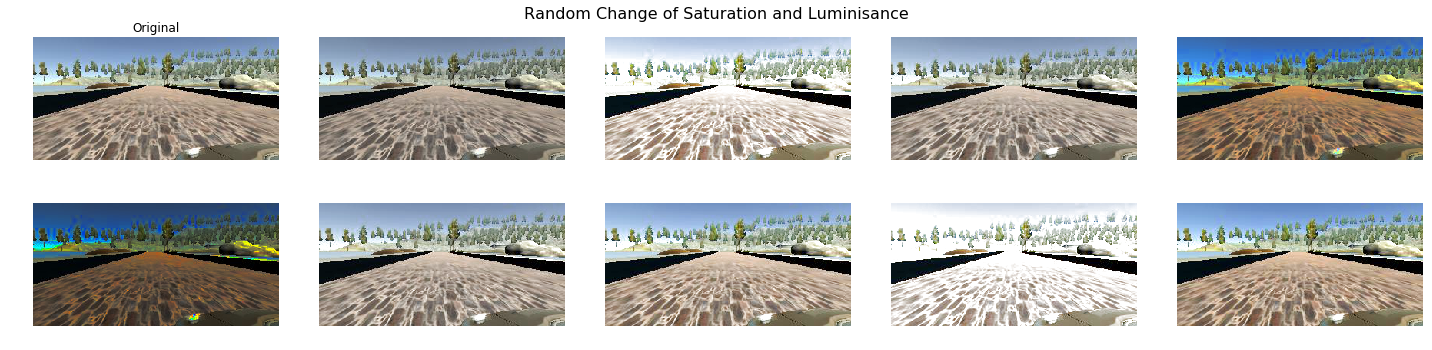

In [13]:
rows = 2
cols = 5

f, ax = plt.subplots(rows, cols, figsize=(cols*4,rows*2.5));

_id = np.random.randint(0, len(samples), 1)[0]
_id = 2017
image = cv2.imread('./data/IMG/' + samples[_id][0].split('/')[-1])

for i in range(0, rows*cols):
    if i == 0:
        ax[0,0].imshow(cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
        ax[0,0].axis('off')
        ax[0,0].set_title("Original")
    else:
        ax[int(i/cols), i%cols].imshow(cv2.cvtColor(modify_sat_lum(image),cv2.COLOR_RGB2BGR))
        ax[int(i/cols), i%cols].axis('off')
        
# Save figure
title = 'Random Change of Saturation and Luminisance'
f.tight_layout()
f.suptitle(title, fontsize=16)
f.subplots_adjust(top=0.95)
f.savefig('./output_images/' + title.replace(" ", "_")+'.jpg')

#### 2. Cast Shadow

In [14]:
def cast_shadow(image):
    # randomly select shadow side
    shadow_side = np.random.choice(['left','right','top', 'bottom'])

    if (shadow_side == 'top') | (shadow_side == 'bottom'):
        divider_left, divider_right = np.random.randint(0, image.shape[0], 2)
    if (shadow_side == 'left') | (shadow_side == 'right'):
        divider_top, divider_bot = np.random.randint(0, image.shape[1], 2)
        
    if shadow_side == 'top':
        ul = [0, 0]
        ur = [image.shape[1], 0]
        ll = [0, divider_left]
        lr = [image.shape[1], divider_right]
    elif shadow_side == 'bottom':
        ul = [0, divider_left]
        ur = [image.shape[1], divider_right]
        ll = [0, image.shape[0]]
        lr = [image.shape[1], image.shape[0]]
    elif shadow_side == 'left':
        ul = [0, 0]
        ur = [divider_top, 0]
        ll = [0, image.shape[0]]
        lr = [divider_bot, image.shape[0]]
    elif shadow_side == 'right':
        ul = [divider_top, 0]
        ur = [image.shape[1], 0]
        ll = [divider_bot, image.shape[0]]
        lr = [image.shape[1], image.shape[0]]

    # form shadow vertices
    vertices = [np.array([ll,ul,ur,lr])]

    # create a blank mask
    mask = np.zeros_like(image[:,:,0])   

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    mask = cv2.fillPoly(mask, vertices, 255).astype('bool')

    # shadow-masked area will be halved its luminanse
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    hls[:,:,1][mask]=hls[:,:,1][mask] * np.random.uniform(0.1, 0.3, 1)

    return cv2.cvtColor(hls.astype('uint8'),cv2.COLOR_HLS2BGR)

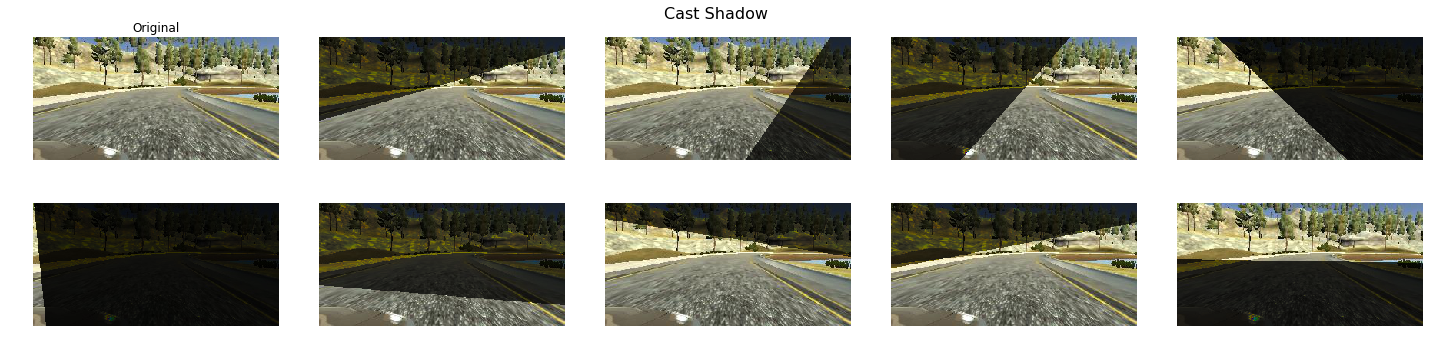

In [15]:
rows = 2
cols = 5

f, ax = plt.subplots(rows, cols, figsize=(cols*4,rows*2.5));

_id = np.random.randint(0, len(samples), 1)[0]
_id = 6361
image = cv2.imread('./data/IMG/' + samples[_id][0].split('/')[-1])

for i in range(0, rows*cols):
    if i == 0:
        ax[0,0].imshow(cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
        ax[0,0].axis('off')
        ax[0,0].set_title("Original")
    else:
        ax[int(i/cols), i%cols].imshow(cv2.cvtColor(cast_shadow(image),cv2.COLOR_RGB2BGR))
        ax[int(i/cols), i%cols].axis('off')
        
# Save figure
title = 'Cast Shadow'
f.tight_layout()
f.suptitle(title, fontsize=16)
f.subplots_adjust(top=0.95)
f.savefig('./output_images/' + title.replace(" ", "_")+'.jpg')

#### 3. Shift Horinzontal and Vertical

In [16]:
def horizontal_vertical_shift(image, steering, hlim=[-60,60], vlim=[-20,20]):
    hlim=sorted(hlim); vlim=sorted(vlim)
    hv_trans= [np.random.randint(hlim[0], hlim[1], 1)[0],
               np.random.randint(vlim[0], vlim[1], 1)[0]]
    trans_img = transform.warp(image, transform.AffineTransform(translation=hv_trans))
    steering = steering + hv_trans[0]*-0.007
    return (trans_img*255).astype('uint8'), steering

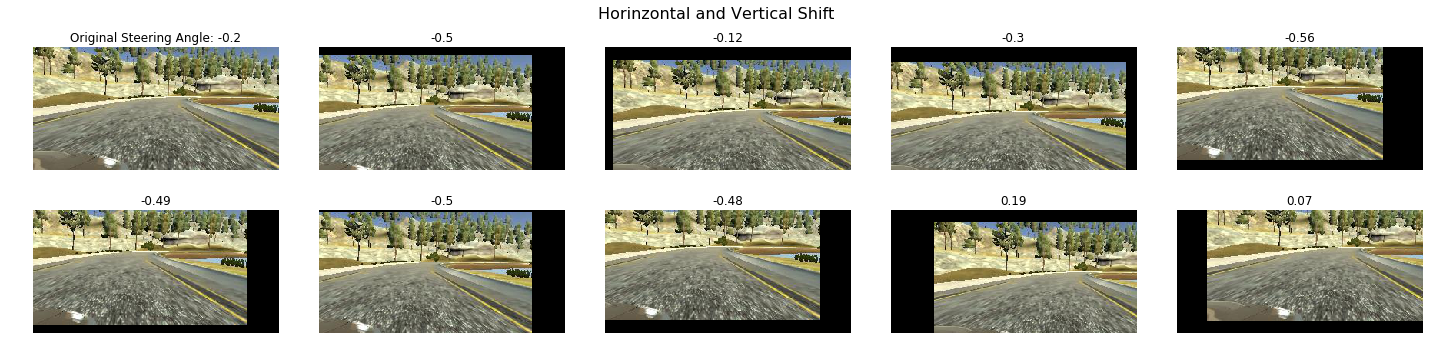

In [17]:
rows = 2
cols = 5

f, ax = plt.subplots(rows, cols, figsize=(cols*4,rows*2.5));

_id = np.random.randint(0, len(samples), 1)[0]
_id = 6361
image = cv2.imread('./data/IMG/' + samples[_id][0].split('/')[-1])
steering = samples[_id][1]
for i in range(0, rows*cols):
    if i == 0:
        ax[0,0].imshow(cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
        ax[0,0].axis('off')
        ax[0,0].set_title("Original Steering Angle: " + str(round(steering, 2)))
    else:
        translated, _steering = horizontal_vertical_shift(image, steering)
        ax[int(i/cols), i%cols].imshow(cv2.cvtColor(translated,cv2.COLOR_RGB2BGR))
        ax[int(i/cols), i%cols].axis('off')
        ax[int(i/cols), i%cols].set_title(str(round(_steering, 2)))
# Save figure
title = 'Horinzontal and Vertical Shift'
f.tight_layout()
f.suptitle(title, fontsize=16)
f.subplots_adjust(top=0.90)
f.savefig('./output_images/' + title.replace(" ", "_")+'.jpg')

#### 4. Rotation

In [18]:
# Reference: https://stackoverflow.com/questions/25895587/python-skimage-transform-affinetransform-rotation-center

In [19]:
def rotate(image, steering, deglim=[-15,15], center=[160,70]):
    degree = np.random.randint(deglim[0], deglim[1], 1)[0]
    # shift the center of single point perspective to origin
    shift_x,shift_y = center
    tf_shift = transform.SimilarityTransform(translation=[-shift_x, -shift_y])

    # perform rotation
    tf_rotate = transform.SimilarityTransform(rotation=np.deg2rad(degree))

    # shifting the center of single point spective to its original location
    tf_shift_inv = transform.SimilarityTransform(translation=[shift_x, shift_y])

    # Warp into final image
    rot_img = transform.warp(image, (tf_shift + (tf_rotate + tf_shift_inv)).inverse)

    _steering = steering + degree*0.02
    return (rot_img*255).astype('uint8'), _steering

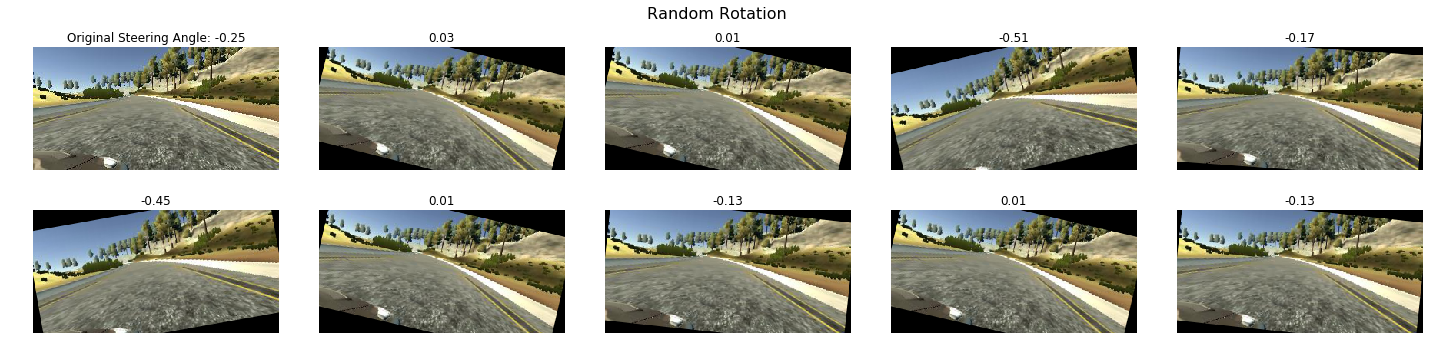

In [20]:
rows = 2
cols = 5

f, ax = plt.subplots(rows, cols, figsize=(cols*4,rows*2.5));

_id = np.random.randint(0, len(samples), 1)[0]
# _id = 6361
image = cv2.imread('./data/IMG/' + samples[_id][0].split('/')[-1])
steering = samples[_id][1]
for i in range(0, rows*cols):
    if i == 0:
        ax[0,0].imshow(cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
        ax[0,0].axis('off')
        ax[0,0].set_title("Original Steering Angle: " + str(round(steering, 2)))
    else:
        rotated, _steering = rotate(image, steering)
        ax[int(i/cols), i%cols].imshow(cv2.cvtColor(rotated,cv2.COLOR_RGB2BGR))
        ax[int(i/cols), i%cols].axis('off')
        ax[int(i/cols), i%cols].set_title(str(round(_steering, 2)))
# Save figure
title = 'Random Rotation'
f.tight_layout()
f.suptitle(title, fontsize=16)
f.subplots_adjust(top=0.90)
f.savefig('./output_images/' + title.replace(" ", "_")+'.jpg')

### Generators

In [21]:
import sklearn
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size = 0.2)

In [22]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: #loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            measurements = []
            
            for batch_sample in batch_samples:
                # Make the file path for center, left and right images
                imgpth = './data/IMG/' + batch_sample[0].split('/')[-1]
                img = cv2.imread(imgpth)
                steering = float(batch_sample[1])
                
                # Chances of perform image augmentation
                if np.random.binomial(1, 0.7) > 0:
                    if np.random.choice([True, False]):
                        if np.random.choice([True, False]):
                            # Random rotation
                            img, steering = rotate(img, steering)
                        else:
                            # Random translation
                            img, steering = horizontal_vertical_shift(img, steering)
                    
                    # Randon lighting conditions
                    if np.random.choice([True, False]):
                        img = modify_sat_lum(img)

                    # Shadow Casting
                    if np.random.choice([True, False]):
                        img = cast_shadow(img)                        
                
                images.append(img)
                measurements.append(steering)

            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

In [23]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

### Model Training in Keras

In [24]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [25]:
model = Sequential()

# Crop Image
x = model.add(Cropping2D(cropping=((70,20), (0,0)), input_shape=(160,320,3)))

# pixel value normalization
model.add(Lambda(lambda x: (x/255.0) - 0.5))

# Conv Layers
model.add(Conv2D(24, (5, 5), strides=(2,2), padding='same', activation='relu'))
model.add(Dropout(0.1, seed=902))
model.add(Conv2D(36, (5, 5), strides=(2,2), padding='same', activation='relu'))
model.add(Dropout(0.1, seed=902))
model.add(Conv2D(48, (5, 5), strides=(2,2), padding='same', activation='relu'))
model.add(Dropout(0.1, seed=902))
model.add(Conv2D(64, (3, 3), strides=(3,3), padding='same', activation='relu'))
model.add(Dropout(0.1, seed=902))
model.add(Conv2D(64, (3, 3), strides=(3,3), padding='same', activation='relu'))
model.add(Dropout(0.1, seed=902))
model.add(Flatten())

# FC Layers
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mse', optimizer = 'adam')# a FC network

filepath="trained_models/commaai-newaug-eph{epoch:02d}-val{val_loss:.3f}.h5"
checkpoint = ModelCheckpoint(filepath)
callbacks_list = [checkpoint]

history_object = model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_samples)*2/32, 
                                     validation_data=validation_generator, 
                                     validation_steps=len(validation_samples)*2/32, 
                                     epochs=10, 
                                     callbacks=callbacks_list)
print(model.summary())

Epoch 1/10
351/350 [==============================] - 157s - loss: 0.1074 - val_loss: 0.0876
Epoch 2/10
351/350 [==============================] - 155s - loss: 0.0863 - val_loss: 0.0812
Epoch 3/10
351/350 [==============================] - 155s - loss: 0.0794 - val_loss: 0.0761
Epoch 4/10
351/350 [==============================] - 155s - loss: 0.0732 - val_loss: 0.0675
Epoch 5/10
351/350 [==============================] - 155s - loss: 0.0694 - val_loss: 0.0644
Epoch 6/10
351/350 [==============================] - 154s - loss: 0.0662 - val_loss: 0.0642
Epoch 7/10
351/350 [==============================] - 156s - loss: 0.0641 - val_loss: 0.0612
Epoch 8/10
351/350 [==============================] - 155s - loss: 0.0643 - val_loss: 0.0610
Epoch 9/10
351/350 [==============================] - 155s - loss: 0.0615 - val_loss: 0.0638
Epoch 10/10
351/350 [==============================] - 155s - loss: 0.0585 - val_loss: 0.0620
_________________________________________________________________
Lay

### Feature Maps

In [25]:
from keras.models import load_model
from keras.models import Sequential, Model

In [26]:
final_model = load_model('trained_models/commaai-newaug-eph07-val0.061.h5')

In [27]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 70, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 160, 24)       1824      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 160, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 80, 36)        21636     
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 80, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 40, 48)         43248     
__________

In [28]:
Input_Layer = Model(inputs=final_model.input, outputs=final_model.get_layer('cropping2d_1').output)
Conv1 = Model(inputs=final_model.input, outputs=final_model.get_layer('conv2d_1').output)
Conv2 = Model(inputs=final_model.input, outputs=final_model.get_layer('conv2d_2').output)
Conv3 = Model(inputs=final_model.input, outputs=final_model.get_layer('conv2d_3').output)

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
center = cv2.imread('./data/IMG/center_2017_09_27_00_27_00_318.jpg')

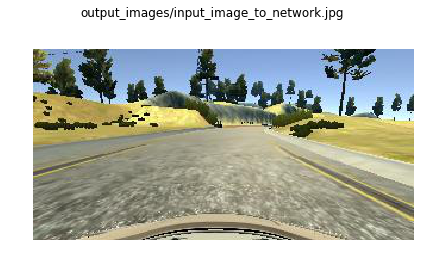

In [31]:
plt.imshow(cv2.cvtColor(center, cv2.COLOR_BGR2RGB))
plt.axis('off')

# save figure
imgpth = 'output_images/input_image_to_network.jpg'
plt.suptitle(imgpth)
plt.tight_layout()
# f.subplots_adjust(top=0.95)
plt.savefig(imgpth)

In [32]:
img = center
img = np.expand_dims(img, axis=0)
steering = final_model.predict(img)
Conv1_FeaMap = Conv1.predict(img)
Conv2_FeaMap = Conv2.predict(img)
Conv3_FeaMap = Conv3.predict(img)

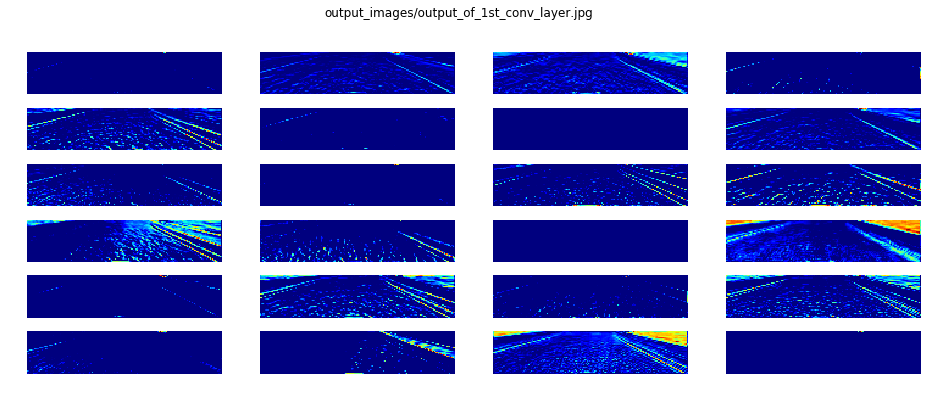

In [33]:
rows = 6
cols = 4

f, ax = plt.subplots(rows, cols, figsize=(cols*4,rows*1));

for i in range(0, rows*cols):
    ax[int(i/cols), i%cols].imshow(Conv1_FeaMap[0,:,:,i], cmap='jet')
    ax[int(i/cols), i%cols].axis('off')
    
# save figure
imgpth = 'output_images/output_of_1st_conv_layer.jpg'
f.suptitle(imgpth)
# f.tight_layout()
# f.subplots_adjust(top=0.95)
f.savefig(imgpth)

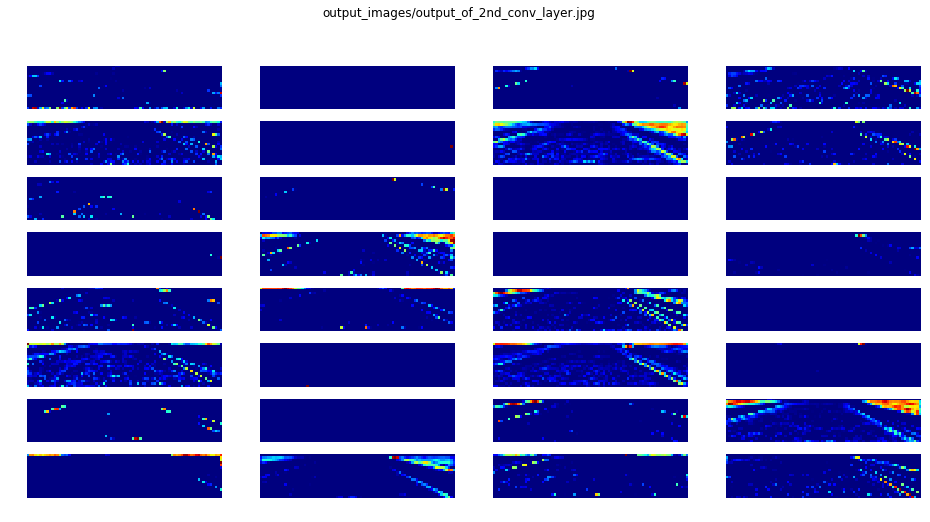

In [34]:
rows = 8
cols = 4

f, ax = plt.subplots(rows, cols, figsize=(cols*4,rows*1));

for i in range(0, rows*cols):
    ax[int(i/cols), i%cols].imshow(Conv2_FeaMap[0,:,:,i], cmap='jet')
    ax[int(i/cols), i%cols].axis('off')
    
# save figure
imgpth = 'output_images/output_of_2nd_conv_layer.jpg'
f.suptitle(imgpth)
# f.tight_layout()
# f.subplots_adjust(top=0.95)
f.savefig(imgpth)